# Notes

Fourth iteration of the modeling:
- classification turn into regression
- modulirized data processing
- model serialization

In [1]:
import os 
import re
import csv
import json
import math
import random
import time

In [2]:
from itertools import chain
from datetime import datetime

In [3]:
import pandas as pd
import numpy as np

In [4]:
import tensorflow as tf

2025-04-06 13:16:50.443193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743938210.629574    8616 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743938210.693282    8616 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-06 13:16:51.179303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Allow memory growth for the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 2 Logical GPUs


I0000 00:00:1743938216.046077    8616 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4882 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1743938216.046621    8616 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5494 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:04:00.0, compute capability: 6.1


In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

Start time

In [7]:
TIME = {}

TIME['start'] = time.time()

# Constants

In [8]:
SEQ_MAX_LEN = 800
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [9]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients')
dir_exercises_augmented = os.path.join(dir_data_root, 'json', 'patients_augmented')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'test')
dir_results = os.path.join(dir_data_root, 'results', 'classification_evaluation')

**TODO** Implement augmenation and patients sessions for the new data set

# Data prep

### Build training set

In [10]:
TIME['data_processing_start'] = time.time()

In [11]:
from utils.input import setup, exercise_to_input

In [12]:
setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'LefteyeMidbottom': 'orbital',
  'LefteyeMidtop': 'orbital',
  'LefteyeInnercorner': 'orbital',
  'LefteyeOutercorner': 'orbital',
  'LefteyebrowInner': 'frontal',
  'LefteyebrowCenter': 'frontal',
  'RighteyeMidbottom': 'orbital',
  'RighteyeMidtop': 'orbital',
  'RighteyeInnercorner': 'orbital',
  'RighteyeOutercorner': 'orbital',
  'RighteyebrowInner': 'frontal',
  'RighteyebrowCenter': 'frontal',
  'NoseTip': 'frontal',
  'MouthLowerlipMidbottom': 'oral',
  'MouthLeftcorner': 'oral',
  'MouthRightcorner': 'oral',
  'MouthUpperlipMidtop': 'oral',
  'ChinCenter': 'oral',
  'ForeheadCenter': 'frontal',
  'LeftcheekCenter': 'oral',
  'RightcheekCenter': 'oral'},
 'BASES': {'LefteyeMidbottom': 'ForeheadCenter',
  'LefteyeMidtop': 'ForeheadCenter',
  'LefteyeInnercorner': 'ForeheadCenter',
  'LefteyeOutercorner': 'ForeheadCenter',
  'LefteyebrowInner': 'ForeheadCenter',
  'LefteyebrowCenter': 'ForeheadCenter

In [13]:
exercises_sources = [
    #dir_exercises_test
    dir_exercises,
    #dir_exercises_augmented
]

In [14]:
feature_engineering_setting = {
    'coordinates': True,
    'normalize_by_start': False,
    'normalize': False,
    'direction': True,
    'distance': True,
    'symetry_diference': False,
    're_base': True,
    'transformation_to_rebase': False,
    'extended_meta': True,
}

In [15]:
count = 0
for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        count += 1

test = int(count*0.2)
training_all = count - test
training = int(training_all*0.8)
validation = training_all - training
print(f'Overall number of examples: {count}')
print(f'Overall number of training examples: {training}')
print(f'Overall number of validation examples: {validation}')
print(f'Overall number of testing examples: {test}')

Overall number of examples: 2419
Overall number of training examples: 1548
Overall number of validation examples: 388
Overall number of testing examples: 483


In [16]:
xslist_meta = list()
xslist_global = list()
xslist_frontal = list()
xslist_oral = list()
xslist_orbital = list()
yslist = list()

for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        file_path = os.path.join(exercise_source, file_name)

        if file_name == '.DS_Store': continue
            
        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_path, feature_engineering_setting)

        yslist.append(_ys)
        xslist_meta.append(_xs_meta)  
        xslist_global.append(_xs_global)
        xslist_frontal.append(_xs_frontal)
        xslist_oral.append(_xs_oral)
        xslist_orbital.append(_xs_orbital)
            
ys = np.array(yslist, dtype='int')
xs_meta = np.array(xslist_meta, dtype='float32')   
xs_global = np.array(xslist_global, dtype='float32') 
xs_frontal = np.array(xslist_frontal, dtype='float32') 
xs_oral = np.array(xslist_oral, dtype='float32') 
xs_orbital = np.array(xslist_orbital, dtype='float32') 

print(ys.shape)
print(xs_meta.shape)
print(xs_global.shape)
print(xs_frontal.shape)
print(xs_oral.shape)
print(xs_orbital.shape)

(2419,)
(2419, 52)
(2419, 168, 800)
(2419, 48, 800)
(2419, 56, 800)
(2419, 64, 800)


Time preprocessing

In [17]:
TIME['data_processing_end'] = time.time()

## Modeling

In [18]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight

In [19]:
def get_dnn(inputLayer, region='default'):     
    m = Dense(4, activation="relu",name=f'{region}-Dense-1')(inputLayer)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [20]:
def get_cnn(inputLayer, region='default'):
    chanDim = -1    
    m = Conv1D(16, 3, padding='same', activation='relu', name=f'{region}-Convolution-1')(inputLayer)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-1')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-1')(m)
    m = Conv1D(32, 3, padding='same', activation='relu', name=f'{region}-Convolution-2')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-2')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-2')(m)
    m = Conv1D(64, 3, padding='same', activation='relu', name=f'{region}-Convolution-3')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-3')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-3')(m)
    m = Conv1D(64, 3, padding='same', activation='relu', name=f'{region}-Convolution-4')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-4')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-4')(m)
    m = Flatten(name=f'{region}-Flatten-1')(m)
    m = Dropout(0.5, name=f'{region}-Dropout-1')(m)
    m = Dense(128, activation="relu", name=f'{region}-Dense-1')(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [21]:
def get_model():
    input_meta = Input(shape=xs_meta.shape[1:], name='Meta-Input')
    model_meta = get_dnn(input_meta, region='Meta')
    
    input_global = Input(shape=xs_global.shape[1:], name='Global-Input')
    model_global = get_cnn(input_global, region='Global')
    
    input_frontal = Input(shape=xs_frontal.shape[1:], name='Frontal-Input')
    model_frontal = get_cnn(input_frontal, region='Frontal')  

    input_oral = Input(shape=xs_oral.shape[1:], name='Oral-Input')
    model_oral = get_cnn(input_oral, region='Oral')  
    
    input_orbital = Input(shape=xs_orbital.shape[1:], name='Orbital-Input')
    model_orbital = get_cnn(input_orbital, region='Orbital')  
    
    
    model_contatenate = concatenate([
        model_meta.output, 
        model_global.output,
        model_frontal.output,
        model_oral.output,
        model_orbital.output,
    ])
    
    model_contatenate = Dense(32, activation="relu")(model_contatenate)
    model_contatenate = Dense(1)(model_contatenate)
        
    model = Model(inputs=[
        model_meta.input,
        model_global.input,
        model_frontal.input,
        model_oral.input,
        model_orbital.input
    ], outputs=model_contatenate)

    initial_learning_rate = 0.001
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    model.compile( 
        loss = tf.keras.losses.mae,
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
        metrics = ['mae']
    )
    
    
    return model

In [22]:
test_model = get_model()
test_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Global-Input        │ (None, 168, 800)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Frontal-Input       │ (None, 48, 800)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Oral-Input          │ (None, 56, 800)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Orbital-Input       │ (None, 64, 800)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Global-Convolution… │ (None, 168, 16)   │     38,416 │ Global-Input[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Frontal-Convolutio… │ (None, 48, 16)    │     38,416 │ Frontal-Input[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Oral-Convolution-1  │ (None, 56, 16)    │     38,416 │ Oral-Input[0][0]  │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Orbital-Convolutio… │ (None, 64, 16)    │     38,416 │ Orbital-Input[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Global-Normalizati… │ (None, 168, 16)   │         64 │ Global-Convoluti… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Frontal-Normalizat… │ (None, 48, 16)    │         64 │ Frontal-Convolut… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Oral-Normalization… │ (None, 56, 16)    │         64 │ Oral-Convolution… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Orbital-Normalizat… │ (None, 64, 16)    │         64 │ Orbital-Convolut… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Global-Pooling-1    │ (None, 84, 16)    │          0 │ Global-Normaliza… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Frontal-Pooling-1   │ (None, 24, 16)    │          0 │ Frontal-Normaliz… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Oral-Pooling-1      │ (None, 28, 16)    │          0 │ Oral-Normalizati… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Orbital-Pooling-1   │ (None, 32, 16)    │          0 │ Orbital-Normaliz… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Global-Convolution… │ (None, 84, 32)    │      1,568 │ Global-Pooling-1

 Total params: 418,133 (1.60 MB)

 Trainable params: 416,725 (1.59 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [23]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


### K-fold evaluation

In [24]:
k = 5
k_limit = 1
train = 0.85
val = 0.5
test = 0.1

In [25]:
VERBOSE = 0
EPOCHS = 10
BATCH_SIZE = 8

In [26]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error

In [27]:
def get_k_indx(k, n):

    k_fold = KFold(n_splits=k)
    train_ = []
    val_ = []
    test_ = []
    indx = []

    for train_indices, test_indices in k_fold.split(ys):
        n_k = len(train_indices)
        val_split = int(n_k * train)
        indx.append([train_indices[:val_split],train_indices[val_split + 1:], test_indices])
    
    return indx

In [28]:
def error_size(ys, ys_pred):
    return [abs(y - y_p) for y, y_p in zip(ys, ys_pred)]

In [29]:
%matplotlib inline

I0000 00:00:1743938864.128964    8784 service.cc:148] XLA service 0x766ae8082a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743938864.129270    8784 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
I0000 00:00:1743938864.129278    8784 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-04-06 13:27:44.526367: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743938866.136121    8784 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-04-06 13:27:48.926257: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more me

 R2 score: -0.6253087377903435
 MEA: 1.8816380525423475
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       225
           1       0.17      0.13      0.15        75
           2       0.17      0.51      0.26        67
           3       0.09      0.38      0.14        32
           4       0.07      0.16      0.10        31
           5       0.10      0.04      0.05        54

    accuracy                           0.13       484
   macro avg       0.10      0.20      0.12       484
weighted avg       0.07      0.13      0.08       484



/home/alan/.cache/pypoetry/virtualenvs/research-face-excercises-dynamics-ZQDiqUbo-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alan/.cache/pypoetry/virtualenvs/research-face-excercises-dynamics-ZQDiqUbo-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alan/.cache/pypoetry/virtualenvs/research-face-excercises-dynamics-ZQDiqUbo-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and b

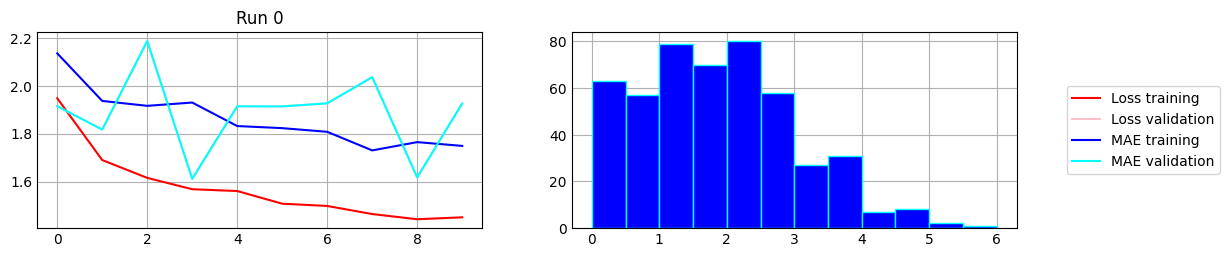

In [30]:
indxs = get_k_indx(k, len(ys))
models = []



for i in range(k_limit):
    TIME[f'k_{i}_training_start'] = time.time()
    train_indx, val_indx, test_indx  = indxs[i]

    xs_meta_i = xs_meta[train_indx]
    xs_meta_i_val = xs_meta[val_indx]
    xs_meta_i_test = xs_meta[test_indx]
    
    xs_global_i = xs_global[train_indx]
    xs_global_i_val = xs_global[val_indx]
    xs_global_i_test = xs_global[test_indx]
    
    xs_frontal_i = xs_frontal[train_indx]
    xs_frontal_i_val = xs_frontal[val_indx]
    xs_frontal_i_test = xs_frontal[test_indx]
    
    xs_oral_i = xs_oral[train_indx]
    xs_oral_i_val = xs_oral[val_indx]
    xs_oral_i_test = xs_oral[test_indx]
    
    xs_orbital_i = xs_orbital[train_indx]
    xs_orbital_i_val = xs_orbital[val_indx]
    xs_orbital_i_test = xs_orbital[test_indx]
    
    ys_i = ys[train_indx]
    ys_i_val = ys[val_indx]
    ys_i_test = ys[test_indx]
    
    
    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(ys_i),
                                                 y=ys_i)
    available_classes = np.unique(ys_i)
        
    weight_training_classes = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
    }
    
    for indx, value in enumerate(class_weights):
        weight_training_classes[available_classes[indx]] = value

    #print(weight_training_classes)

    model = get_model()

    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(start_from_epoch=100, patience=40)
    ]

    hist = model.fit(
        x=[
            xs_meta_i, 
            xs_global_i, 
            xs_frontal_i,
            xs_oral_i,
            xs_orbital_i], y=ys_i, 
        validation_data=([
            xs_meta_i_val,
            xs_global_i_val,
            xs_frontal_i_val,
            xs_oral_i_val,
            xs_orbital_i_val], ys_i_val),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        class_weight=weight_training_classes,
        #callbacks=model_callbacks,
        verbose=VERBOSE)
    
    models.append(model)

    TIME[f'k_{i}_training_end'] = time.time()
    TIME[f'k_{i}_evaluation_start'] = time.time()

    ### EVALUATION
    y_pred = model.predict([
        xs_meta_i_test,
        xs_global_i_test,
        xs_frontal_i_test,
        xs_oral_i_test,
        xs_orbital_i_test],verbose=0)
    #print(y_pred)
    y_pred_classification = np.round(y_pred.flatten())
    for idx, x in np.ndenumerate(y_pred_classification):
        if x > 5: y_pred_classification[idx] = 5
        if x < 0: y_pred_classification[idx] = 0

    y_pred_regression = y_pred.flatten()
    print(f' R2 score: {r2_score(ys_i_test, y_pred_regression)}')
    print(f' MEA: {mean_absolute_error(ys_i_test, y_pred_regression)}')
    print(classification_report(ys_i_test, y_pred_classification))

    ### VISUALISATION
    fig, axs = plt.subplots(1,2,figsize=(10,2)) 
    colors = ['red', 'pink', 'blue', 'cyan']
    labels = ['Loss training', 'Loss validation', 'MAE training', 'MAE validation']
    
    train_loss = hist.history['loss']
    val_loss   = hist.history['val_loss']
    train_acc  = hist.history['mae']
    val_acc    = hist.history['val_mae']
    xc         = range(len(hist.history['loss']))    
    
    axs[0].set_title(f'Run {i}')
    axs[0].plot(xc, train_loss, color=colors[0], label=labels[0])
    axs[0].plot(xc, val_loss, color=colors[1], label=labels[1])
    axs[0].plot(xc, train_acc, color=colors[2], label=labels[2])
    axs[0].plot(xc, val_acc, color=colors[3], label=labels[3])
    
    errors = error_size(ys_i_test, y_pred_regression)
    axs[1].hist(errors, bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6], color=colors[2], edgecolor=colors[3])
    
    fig.legend(labels, ncol=1, bbox_to_anchor=(1.2,0.5), loc='center right', fontsize=10, bbox_transform=plt.gcf().transFigure)
    fig.savefig(os.path.join(dir_results, f'mphnn_model_v05_run_{i}_{int(time.time())}.svg'), format='svg', dpi=1200, bbox_inches='tight')  
    plt.show()


End time

In [31]:
TIME['end'] = time.time()

In [32]:
print(f'Total processing took {TIME["end"] - TIME["start"]}')
print(f'Data processing took {TIME["data_processing_end"] - TIME["data_processing_start"]}')
for i in range(k_limit):
    print(f'Run {i} took training {TIME[f"k_{i}_training_end"] - TIME[f"k_{i}_training_start"]} evaluation {TIME[f"k_{i}_evaluation_end"] - TIME[f"k_{i}_evaluation_start"]}')


Total processing took 702.7354834079742
Data processing took 632.7318768501282


KeyError: 'k_0_evaluation_end'

In [ ]:
a = [2.924945831298828, 3.651282787322998, 4.806945085525513, 5.401340961456299, 6.65657901763916]
(sum(a)/len(a))/484

In [ ]:
a = [1600.00035572052, 1513.8305730819702, 1569.2452821731567, 1600.6460349559784, 1670.5405218601227]
(sum(a)/len(a))

In [ ]:
9.362757205963135 / 2419

# Model Serialization 

In [ ]:
serialize = True
best_model = 2

In [ ]:
dir_models = os.path.join(dir_root, 'models')
dir_model = os.path.join(dir_models, 'type5-001')

In [ ]:
if serialize:
    model = models[best_model]
    model.save(dir_model)